In [1]:
import pandas as pd
from Preprocessing_functions import split_owner
from functools import reduce
import numpy as np


In [2]:
def split_owner(owner_str):
    """
    Given an owner string like:
    - "Örsted [10%]; Felvig [90%]"  OR
    - "Owner1; Owner2" 
    returns a list of tuples (owner_name, fraction).
    
    If no percentages are provided for multiple owners, each is assigned an equal share.
    If some owners lack percentages while others have them, the remaining percentage is equally
    distributed among those missing percentages.
    """
    if not isinstance(owner_str, str):
        return [("Unknown", 1.0)]


    # Split the string by semicolon to handle multiple owners
    parts = [part.strip() for part in owner_str.split(';')]
    
    # Check if any part contains a percentage
    has_percentage = any('[' in part and ']' in part for part in parts)
    
    result = []
    
    if not has_percentage:
        # No percentages provided: assign equal share to each owner.
        equal_share = 1.0 / len(parts)
        for part in parts:
            # Clean the owner name in case any extraneous text exists
            name = part.split('[')[0].strip()
            result.append((name, equal_share))
    else:
        # Process each part: extract percentage if available.
        for part in parts:
            if '[' in part and ']' in part:
                name = part.split('[')[0].strip()
                percentage_str = part.split('[')[1].split(']')[0].strip().replace('%', '')
                try:
                    percentage = float(percentage_str) / 100.0
                except ValueError:
                    percentage = None
                result.append((name, percentage))
            else:
                # Part without a percentage: mark fraction as None for now.
                result.append((part, None))
        
        # For parts that are missing percentages, assign an equal share of the remaining capacity.
        total_assigned = sum(p for _, p in result if p is not None)
        missing_count = sum(1 for _, p in result if p is None)
        if missing_count > 0:
            remaining = max(0, 1.0 - total_assigned)  # Avoid negative
            missing_share = remaining / missing_count
            result = [(name, p if p is not None else missing_share) for name, p in result]
    
    return result

# Assume merged_bio is your DataFrame containing the "Owner" and "Capacity (MW)" columns.
# For example, if reading from CSV:
# merged_bio = pd.read_csv("Bioenergy_merged.csv")

# Create a new list to store expanded rows



In [3]:
df_over = pd.read_csv("Data/Bioenergy_overthresh.csv")
df_under = pd.read_csv("Data/Bioenergy_underthresh.csv")

# Concatenate the DataFrames vertically (row-wise)
Bio_df = pd.concat([df_over, df_under], ignore_index=True)
Active_bio_df = Bio_df[Bio_df['Status'] == 'operating']
Active_bio_df.rename(columns={'Owner(s)': 'Owner'}, inplace=True)
Active_bio_df.rename(columns={'Country/Area': 'Country'}, inplace=True)


expanded_rows = []

for idx, row in Active_bio_df.iterrows():
    capacity = row["Capacity (MW)"]
    owner_str = row["Owner"]
    owners = split_owner(owner_str)
    for name, fraction in owners:
        new_row = row.copy()
        new_row["Owner"] = name  # Set the individual owner name
        # Calculate the attributed capacity. If fraction is None for some reason, use full capacity.
        new_row["Attributed Capacity (MW)"] = capacity * fraction if fraction is not None else capacity
        expanded_rows.append(new_row)

# Create a new DataFrame from the expanded rows
expanded_df = pd.DataFrame(expanded_rows)

# Optionally, group by owner to get total attributed capacity per company
Bio_capacity_by_company = (
    expanded_df
      .groupby(['Region', 'Country', 'Owner'], as_index=False)['Attributed Capacity (MW)']
      .sum()
)
# Display the result
sum(Bio_capacity_by_company['Attributed Capacity (MW)'])

/var/folders/7j/s2kkprgj0zx6hrn11xc4tlwc0000gp/T/ipykernel_74025/3490475021.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Active_bio_df.rename(columns={'Owner(s)': 'Owner'}, inplace=True)
/var/folders/7j/s2kkprgj0zx6hrn11xc4tlwc0000gp/T/ipykernel_74025/3490475021.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Active_bio_df.rename(columns={'Country/Area': 'Country'}, inplace=True)


84316.87

In [4]:
Coal_df = pd.read_csv("Data/Coal.csv")
Active_Coal_df = Coal_df[Coal_df['Status'] == 'operating']
Active_Coal_df.rename(columns={'Country/Area': 'Country'}, inplace=True)


expanded_rows = []

for idx, row in Active_Coal_df.iterrows():
    capacity = row["Capacity (MW)"]
    owner_str = row["Parent"]
    owners = split_owner(owner_str)
    for name, fraction in owners:
        new_row = row.copy()
        new_row["Owner"] = name  # Set the individual owner name
        # Calculate the attributed capacity. If fraction is None for some reason, use full capacity.
        new_row["Attributed Capacity (MW)"] = capacity * fraction if fraction is not None else capacity
        expanded_rows.append(new_row)

# Create a new DataFrame from the expanded rows
expanded_df = pd.DataFrame(expanded_rows)

# Optionally, group by owner to get total attributed capacity per company
Coal_capacity_by_company = (
    expanded_df
      .groupby(['Region', 'Country', 'Owner'], as_index=False)['Attributed Capacity (MW)']
      .sum()
)
# Display the result
sum(Coal_capacity_by_company['Attributed Capacity (MW)'])



/var/folders/7j/s2kkprgj0zx6hrn11xc4tlwc0000gp/T/ipykernel_74025/3983875016.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Active_Coal_df.rename(columns={'Country/Area': 'Country'}, inplace=True)


2140264.5022000014

In [5]:
df_over = pd.read_csv("Data/Geothermal_overthresh.csv")
df_under = pd.read_csv("Data/Geothermal_underthres.csv")

# Concatenate the DataFrames vertically (row-wise)
Geo_df = pd.concat([df_over, df_under], ignore_index=True)

Active_Geo_df = Geo_df[Geo_df['Status'] == 'operating']
Active_Geo_df.rename(columns={'Country/Area': 'Country'}, inplace=True)


expanded_rows = []

for idx, row in Active_Geo_df.iterrows():
    capacity = row["Capacity (MW)"]
    owner_str = row["Owner"]
    owners = split_owner(owner_str)
    for name, fraction in owners:
        new_row = row.copy()
        new_row["Owner"] = name  # Set the individual owner name
        # Calculate the attributed capacity. If fraction is None for some reason, use full capacity.
        new_row["Attributed Capacity (MW)"] = capacity * fraction if fraction is not None else capacity
        expanded_rows.append(new_row)

# Create a new DataFrame from the expanded rows
expanded_df = pd.DataFrame(expanded_rows)

# Optionally, group by owner to get total attributed capacity per company
Geo_capacity_by_company = (
    expanded_df
      .groupby(['Region', 'Country', 'Owner'], as_index=False)['Attributed Capacity (MW)']
      .sum()
)
# Display the result
sum(Geo_capacity_by_company['Attributed Capacity (MW)'])

/var/folders/7j/s2kkprgj0zx6hrn11xc4tlwc0000gp/T/ipykernel_74025/2451580784.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Active_Geo_df.rename(columns={'Country/Area': 'Country'}, inplace=True)


13908.74

In [6]:
Geo_capacity_by_company

,Region,Country,Owner,Attributed Capacity (MW)
0,Africa,Kenya,Geothermal Development Company (GDC),35.0
1,Africa,Kenya,Kenya Electricity Generating Company PLC,632.0
2,Africa,Kenya,Ormat Technology INC,147.0
3,Americas,Chile,Empresa Nacional del Petróleo,40.5
4,Americas,Chile,Enel Chile,40.5
...,...,...,...,...
81,Oceania,New Zealand,Mighty River Power,204.0
82,Oceania,New Zealand,Tauhara North 2 Trust,52.0
83,Oceania,New Zealand,Top Energy LTD,32.0
84,Oceania,New Zealand,Tuaropaki Power Company,82.5


In [7]:
df_over = pd.read_csv("Data/Hydro_overthresh.csv")
df_under = pd.read_csv("Data/Hydro_underhresh.csv")

# Concatenate the DataFrames vertically (row-wise)
Hydro_df = pd.concat([df_over, df_under], ignore_index=True)

Active_Hydro_df = Hydro_df[Hydro_df['Status'] == 'operating']
Active_Hydro_df.rename(columns={'Country 1': 'Country'}, inplace=True)
Active_Hydro_df.rename(columns={'Region 1': 'Region'}, inplace=True)

expanded_rows = []

for idx, row in Active_Hydro_df.iterrows():
    capacity = row["Capacity (MW)"]
    owner_str = row["Owner"]
    owners = split_owner(owner_str)
    for name, fraction in owners:
        new_row = row.copy()
        new_row["Owner"] = name  # Set the individual owner name
        # Calculate the attributed capacity. If fraction is None for some reason, use full capacity.
        new_row["Attributed Capacity (MW)"] = capacity * fraction if fraction is not None else capacity
        expanded_rows.append(new_row)

# Create a new DataFrame from the expanded rows
expanded_df = pd.DataFrame(expanded_rows)

# Optionally, group by owner to get total attributed capacity per company
Hydro_capacity_by_company = (
    expanded_df
      .groupby(['Region', 'Country', 'Owner'], as_index=False)['Attributed Capacity (MW)']
      .sum()
)
# Display the result
sum(Hydro_capacity_by_company['Attributed Capacity (MW)'])


/var/folders/7j/s2kkprgj0zx6hrn11xc4tlwc0000gp/T/ipykernel_74025/4126796708.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Active_Hydro_df.rename(columns={'Country 1': 'Country'}, inplace=True)
/var/folders/7j/s2kkprgj0zx6hrn11xc4tlwc0000gp/T/ipykernel_74025/4126796708.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Active_Hydro_df.rename(columns={'Region 1': 'Region'}, inplace=True)


1136616.6191399996

In [8]:
Nuclear_df = pd.read_csv("Data/Nuclear.csv")

# Filter rows where 'Status' is 'operating'
Active_Nuclear_df = Nuclear_df[Nuclear_df['Status'] == 'operating']

# Convert the " Capacity (MW) " column to numeric, without replacing the whole DataFrame
Active_Nuclear_df.loc[:, " Capacity (MW) "] = pd.to_numeric(Active_Nuclear_df[" Capacity (MW) "], errors="coerce")
Active_Nuclear_df.rename(columns={'Country/Area': 'Country'}, inplace=True)
Active_Nuclear_df.rename(columns={" Capacity (MW) ": "Capacity (MW)"}, inplace=True)

expanded_rows = []

# Process each row to attribute capacity based on the split_owner function
for idx, row in Active_Nuclear_df.iterrows():
    capacity = row["Capacity (MW)"]
    owner_str = row["Owner"]
    owners = split_owner(owner_str)
    for name, fraction in owners:
        new_row = row.copy()
        new_row["Owner"] = name  # Set the individual owner name
        # Calculate the attributed capacity. If fraction is None for some reason, use full capacity.
        new_row["Attributed Capacity (MW)"] = capacity * fraction if fraction is not None else capacity
        expanded_rows.append(new_row)

# Create a new DataFrame from the expanded rows
expanded_df = pd.DataFrame(expanded_rows)

# Group by owner to get total attributed capacity per company
Nuclear_capacity_by_company = (
    expanded_df
      .groupby(['Region', 'Country', 'Owner'], as_index=False)['Attributed Capacity (MW)']
      .sum()
)
# Display the result: sum of attributed capacity across all companies
total_capacity = sum(Nuclear_capacity_by_company['Attributed Capacity (MW)'])
print("Total Attributed Capacity (MW):", total_capacity)

/var/folders/7j/s2kkprgj0zx6hrn11xc4tlwc0000gp/T/ipykernel_74025/660993519.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Active_Nuclear_df.rename(columns={'Country/Area': 'Country'}, inplace=True)
/var/folders/7j/s2kkprgj0zx6hrn11xc4tlwc0000gp/T/ipykernel_74025/660993519.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Active_Nuclear_df.rename(columns={" Capacity (MW) ": "Capacity (MW)"}, inplace=True)


Total Attributed Capacity (MW): 396484.00000000006


In [9]:
df_over = pd.read_csv("Data/Wind_overthresh.csv")
df_under = pd.read_csv("Data/Wind_underthresh.csv")

# Concatenate the DataFrames vertically (row-wise)
Wind_df = pd.concat([df_over, df_under], ignore_index=True)


Active_Wind_df = Wind_df[Wind_df['Status'] == 'operating']
Active_Wind_df.rename(columns={'Country/Area': 'Country'}, inplace=True)


expanded_rows = []

for idx, row in Active_Wind_df.iterrows():
    capacity = row["Capacity (MW)"]
    owner_str = row["Owner"]
    owners = split_owner(owner_str)
    for name, fraction in owners:
        new_row = row.copy()
        new_row["Owner"] = name  # Set the individual owner name
        # Calculate the attributed capacity. If fraction is None for some reason, use full capacity.
        new_row["Attributed Capacity (MW)"] = capacity * fraction if fraction is not None else capacity
        expanded_rows.append(new_row)

# Create a new DataFrame from the expanded rows
expanded_df = pd.DataFrame(expanded_rows)

# Optionally, group by owner to get total attributed capacity per company
Wind_capacity_by_company = (
    expanded_df
      .groupby(['Region', 'Country', 'Owner'], as_index=False)['Attributed Capacity (MW)']
      .sum()
)
# Display the result
sum(Wind_capacity_by_company['Attributed Capacity (MW)'])

/var/folders/7j/s2kkprgj0zx6hrn11xc4tlwc0000gp/T/ipykernel_74025/1691953202.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Active_Wind_df.rename(columns={'Country/Area': 'Country'}, inplace=True)


1005066.9999999985

In [10]:
Areas_coal = set(Coal_df.loc[:,'Subregion'])
Areas_Wind = set(Wind_df.loc[:,'Subregion'])
print(Areas_coal)
print(Areas_Wind)

{'Northern Europe', 'Central Asia', 'Northern America', 'Southern Asia', 'Eastern Europe', 'Western Asia', 'Melanesia', 'Sub-Saharan Africa', 'Latin America and the Caribbean', 'Southern Europe', 'Western Europe', 'Australia and New Zealand', 'Northern Africa', 'South-eastern Asia', 'Eastern Asia'}
{'Northern Europe', 'Central Asia', 'Micronesia', 'Northern America', 'Southern Asia', 'Western Asia', 'Polynesia', 'Eastern Europe', 'Melanesia', 'Sub-Saharan Africa', 'Latin America and the Caribbean', 'Southern Europe', 'Western Europe', 'Australia and New Zealand', 'Northern Africa', 'South-eastern Asia', 'Eastern Asia'}


In [11]:
df_over = pd.read_csv("Data/Oil_Gas_overthresh.csv")
df_under = pd.read_csv("Data/Oil_Gas_underthresh.csv")

# Concatenate the DataFrames vertically (row-wise)
OilGas_df = pd.concat([df_over, df_under], ignore_index=True)
OilGas_df.rename(columns={'Country/Area': 'Country'}, inplace=True)

Active_OilGas_df = OilGas_df[OilGas_df['Status'] == 'operating']
Active_OilGas_df.rename(columns={'Owner(s)': 'Owner'}, inplace=True)
Active_Gas_df = Active_OilGas_df[Active_OilGas_df['Fuel'].str.contains('gas', case=False, na=False)].copy()
Active_Oil_df = Active_OilGas_df[~Active_OilGas_df['Fuel'].str.contains('gas', case=False, na=False)].copy()

expanded_rows = []

for idx, row in Active_Oil_df.iterrows():
    capacity = row["Capacity (MW)"]
    owner_str = row["Owner"]
    owners = split_owner(owner_str)
    for name, fraction in owners:
        new_row = row.copy()
        new_row["Owner"] = name  # Set the individual owner name
        # Calculate the attributed capacity. If fraction is None for some reason, use full capacity.
        new_row["Attributed Capacity (MW)"] = capacity * fraction if fraction is not None else capacity
        expanded_rows.append(new_row)

# Create a new DataFrame from the expanded rows
expanded_df = pd.DataFrame(expanded_rows)


# Optionally, group by owner to get total attributed capacity per company
Oil_capacity_by_company = (
    expanded_df
      .groupby(['Region', 'Country', 'Owner'], as_index=False)['Attributed Capacity (MW)']
      .sum()
)
for idx, row in Active_Gas_df.iterrows():
    capacity = row["Capacity (MW)"]
    owner_str = row["Owner"]
    owners = split_owner(owner_str)
    for name, fraction in owners:
        new_row = row.copy()
        new_row["Owner"] = name  # Set the individual owner name
        # Calculate the attributed capacity. If fraction is None for some reason, use full capacity.
        new_row["Attributed Capacity (MW)"] = capacity * fraction if fraction is not None else capacity
        expanded_rows.append(new_row)

# Create a new DataFrame from the expanded rows
expanded_df = pd.DataFrame(expanded_rows)


# Optionally, group by owner to get total attributed capacity per company
Gas_capacity_by_company = (
    expanded_df
      .groupby(['Region', 'Country', 'Owner'], as_index=False)['Attributed Capacity (MW)']
      .sum()
)
# Display the result
sum(Gas_capacity_by_company['Attributed Capacity (MW)'])

/var/folders/7j/s2kkprgj0zx6hrn11xc4tlwc0000gp/T/ipykernel_74025/2785838427.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Active_OilGas_df.rename(columns={'Owner(s)': 'Owner'}, inplace=True)


2162682.079999999

In [12]:
df_over = pd.read_csv("Data/Solar_overthresh.csv")
df_under = pd.read_csv("Data/Solar_underthresh.csv")

# Concatenate the DataFrames vertically (row-wise)
Solar_df = pd.concat([df_over, df_under], ignore_index=True)

Active_Solar_df = Solar_df[Solar_df['Status'] == 'operating']
Active_Solar_df.rename(columns={'Country/Area': 'Country'}, inplace=True)


expanded_rows = []

for idx, row in Active_Solar_df.iterrows():
    capacity = row["Capacity (MW)"]
    owner_str = row["Owner"]
    owners = split_owner(owner_str)
    for name, fraction in owners:
        new_row = row.copy()
        new_row["Owner"] = name  # Set the individual owner name
        # Calculate the attributed capacity. If fraction is None for some reason, use full capacity.
        new_row["Attributed Capacity (MW)"] = capacity * fraction if fraction is not None else capacity
        expanded_rows.append(new_row)

# Create a new DataFrame from the expanded rows
expanded_df = pd.DataFrame(expanded_rows)

# Optionally, group by owner to get total attributed capacity per company
Solar_capacity_by_company = (
    expanded_df
      .groupby(['Region', 'Country', 'Owner'], as_index=False)['Attributed Capacity (MW)']
      .sum()
)
# Display the result
sum(Solar_capacity_by_company['Attributed Capacity (MW)'])

/var/folders/7j/s2kkprgj0zx6hrn11xc4tlwc0000gp/T/ipykernel_74025/601977210.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Active_Solar_df.rename(columns={'Country/Area': 'Country'}, inplace=True)


991109.9999999999

In [48]:



# 2. Build a master list of unique owners across all DataFrames
dataframes = [
    Solar_capacity_by_company,
    Wind_capacity_by_company,
    Nuclear_capacity_by_company,
    Coal_capacity_by_company,
    Hydro_capacity_by_company,
    Gas_capacity_by_company,
    Oil_capacity_by_company,
    Bio_capacity_by_company,
    Geo_capacity_by_company
]



# 1. Rename each DataFrame’s capacity column to a unique name
Solar_capacity_by_company = Solar_capacity_by_company.rename(
    columns={'Attributed Capacity (MW)': 'Solar_capacity'}
)
Wind_capacity_by_company = Wind_capacity_by_company.rename(
    columns={'Attributed Capacity (MW)': 'Wind_capacity'}
)
Nuclear_capacity_by_company = Nuclear_capacity_by_company.rename(
    columns={'Attributed Capacity (MW)': 'Nuclear_capacity'}
)
Coal_capacity_by_company = Coal_capacity_by_company.rename(
    columns={'Attributed Capacity (MW)': 'Coal_capacity'}
)
Hydro_capacity_by_company = Hydro_capacity_by_company.rename(
    columns={'Attributed Capacity (MW)': 'Hydro_capacity'}
)
Oil_capacity_by_company = Oil_capacity_by_company.rename(
    columns={'Attributed Capacity (MW)': 'Oil_capacity'}
)
Gas_capacity_by_company = Gas_capacity_by_company.rename(
    columns={'Attributed Capacity (MW)': 'Gas_capacity'}
)
Bio_capacity_by_company = Bio_capacity_by_company.rename(
    columns={'Attributed Capacity (MW)': 'Bio_capacity'}
)
Geo_capacity_by_company = Geo_capacity_by_company.rename(
    columns={'Attributed Capacity (MW)': 'Geo_capacity'}
)

df_merged = reduce(
    lambda left, right: pd.merge(
        left, right,
        on=['Region', 'Country', 'Owner'],
        how='outer'
    ),
    dataframes
)

capacity_cols = [col for col in df_merged.columns if 'capacity' in col]
df_merged['total_capacity'] = df_merged[capacity_cols].sum(axis=1)

# 3. Sort by this new total_capacity column in descending order
df_merged_sorted = df_merged.sort_values(by='total_capacity', ascending=False)

# 4. Select the top 20 rows

# 1) Define the region‐by‐region capacity factors (0–1) for each source
cf_by_region = {
       # Africa
    "Africa": {
        "Solar_capacity":    0.16,
        "Wind_capacity":     0.25,
        "Nuclear_capacity":  0.60,
        "Coal_capacity":     0.60,
        "Hydro_capacity":    0.20,
        "Gas_capacity":      0.30,
        "Oil_capacity":      0.30,
        "Bio_capacity":      0.40,
        "Geo_capacity":      0.70,
    },
    # Americas (North + South)
    "Americas": {
        "Solar_capacity":    0.19,
        "Wind_capacity":     0.33,
        "Nuclear_capacity":  0.90,
        "Coal_capacity":     0.50,
        "Hydro_capacity":    0.45,
        "Gas_capacity":      0.35,
        "Oil_capacity":      0.35,
        "Bio_capacity":      0.50,
        "Geo_capacity":      0.75,
    },
    # Asia
    "Asia": {
        "Solar_capacity":    0.15,
        "Wind_capacity":     0.25,
        "Nuclear_capacity":  0.80,
        "Coal_capacity":     0.55,
        "Hydro_capacity":    0.40,
        "Gas_capacity":      0.40,
        "Oil_capacity":      0.40,
        "Bio_capacity":      0.50,
        "Geo_capacity":      0.80,
    },
    # Europe
    "Europe": {
        "Solar_capacity":    0.12,
        "Wind_capacity":     0.3,
        "Nuclear_capacity":  0.85,
        "Coal_capacity":     0.40,
        "Hydro_capacity":    0.4,
        "Gas_capacity":      0.40,
        "Oil_capacity":      0.33,
        "Bio_capacity":      0.50,
        "Geo_capacity":      0.80,
    },
    # Oceania
    "Oceania": {
        "Solar_capacity":    0.19,
        "Wind_capacity":     0.30,
        "Nuclear_capacity":  np.nan,
        "Coal_capacity":     0.60,
        "Hydro_capacity":    0.30,
        "Gas_capacity":      0.20,
        "Oil_capacity":      0.20,
        "Bio_capacity":      0.50,
        "Geo_capacity":      0.80,
    },
}

# 2) For each region, vector‐apply its factors
for region, factors in cf_by_region.items():
    mask = df_merged_sorted["Region"] == region

    for cap_col, factor in factors.items():
        gen_col = cap_col.replace("_capacity", "_generation")
        df_merged_sorted.loc[mask, gen_col] = (
            df_merged_sorted.loc[mask, cap_col]
            * factor
            * 8760       # hours/year
            / 1_000_000  # to convert from MW·h to TWh
        )

# 3) If any companies didn’t match a region (mask never True), 
#    you can fill with a default factor or with NaNs now.

# 4) Recompute your totals
generation_cols = [
    c for c in df_merged_sorted.columns
    if c.endswith("_generation")
]
df_merged_sorted["total_generation"] = (
    df_merged_sorted[generation_cols].sum(axis=1)
)

In [51]:
df_Italian_companies = df_merged_sorted[df_merged_sorted["Country"] == 'Italy']   # ← NEW LINE
unique_owner_count = df_Italian_companies["Owner"].unique()
print(unique_owner_count)

['Enel SpA' 'Enel SPA' 'Edison SpA' 'A2A SpA' 'Unknown'
 'EP Produzione SpA' 'Eni SpA' 'Sorgenia SpA' 'Tirreno Power SpA'
 'A2A Energiefuture' 'A2A' 'Iren Energia SpA' 'Enel Produzione SpA'
 'Enipower SpA' 'Metaenergia SpA' 'ERG SpA' 'Taranto Energia SRL'
 'Enel Green Power SpA' 'Dolomiti Energia' 'Ergosud SpA'
 'EP Produzione Centrale Livorno Ferraris SpA' 'Enipower Mantova SpA'
 'Iren SpA' 'Engie Italia SpA' 'Rizziconi Energia SpA'
 'Enipower Ferrara SRL' 'Calenia Energia SpA' 'Alperia'
 'Energetický a průmyslový holding AS' 'Saras SpA' 'Fri-El SpA'
 'E2i Energie Speciali Srl' 'Cogeneration Rosignano SpA'
 'Alerion Clean Power' 'ENGIE SA' 'ISAB Energy SRL' 'Edison SPA'
 'RWE Renewables' 'Brown2Green Sicily SRL' 'EDF Renewables'
 'EDPR Renewable Energy Sources of Greece 1 Sole Proprietorship'
 'Repower AG' 'Enplus' 'Eni Rewind SpA' 'Enel Green Power'
 'Tecnoparco Valbasento SpA' 'Tozzi Sud SpA'
 'Fondi Italiani per le Infrastrutture SGR SpA' 'Renantis UK Ltd'
 'Fortore Energia SpA' 'I

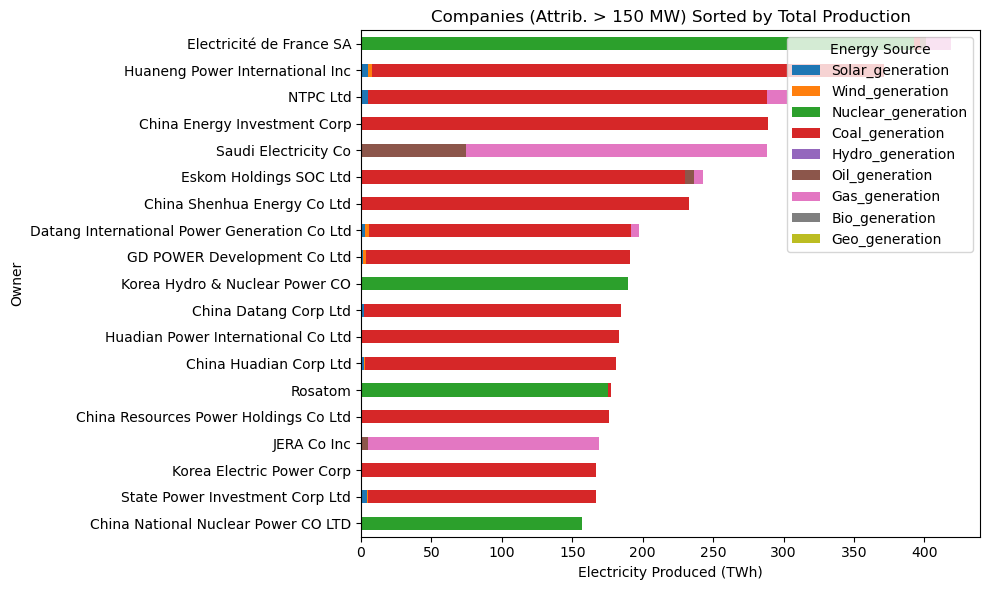

In [18]:
import matplotlib.pyplot as plt

# the columns you want to stack
plot_cols = [
    "Solar_generation",
    "Wind_generation",
    "Nuclear_generation",
    "Coal_generation",
    "Hydro_generation",
    "Oil_generation",
    "Gas_generation",
    "Bio_generation",
    "Geo_generation",
]

df_plot = df_merged_sorted.iloc[1:].copy()

# keep only companies whose attributed capacity > 150 MW
df_plot = df_plot[df_plot["total_generation"] > 150]   # ← NEW LINE

# -----------------------------------------------------------------------------
# 1) SORT BY TOTAL PRODUCTION
# -----------------------------------------------------------------------------
df_plot["Total"] = df_plot[plot_cols].sum(axis=1)
df_total = df_plot.sort_values("Total")

ax = df_total.plot(
    kind="barh",
    x="Owner",
    y=plot_cols,
    stacked=True,
    figsize=(10, 6),
)
ax.set_xlabel("Electricity Produced (TWh)")
ax.set_title("Companies (Attrib. > 150 MW) Sorted by Total Production")
ax.legend(title="Energy Source", loc="upper right")
plt.tight_layout()
plt.show()

In [ ]:
df_merged_sorted


,Owner,Solar_capacity,Wind_capacity,Nuclear_capacity,Coal_capacity,Hydro_capacity,OilGas_capacity,Bio_capacity,Geo_capacity,total_capacity,Solar_generation,Wind_generation,Nuclear_generation,Coal_generation,Hydro_generation,OilGas_generation,Bio_generation,Geo_generation,total_estimated_generation
12923,Unknown,253479.200000,233793.200000,5.0,500.000000,39586.0727,4194.600,11598.0,537.0,543693.072700,399.686003,593.928245,0.034602,2.014800,145.645079,16.535113,57.911134,3.292884,1219.047859
6002,Huaneng Power International Inc,3570.000000,1298.000000,NaN,75511.770000,NaN,NaN,60.0,NaN,80439.770000,5.629176,3.297439,NaN,304.282228,NaN,NaN,0.299592,NaN,313.508436
3574,Electricité de France SA,NaN,NaN,64040.0,1260.000000,NaN,5477.700,NaN,NaN,70777.700000,NaN,NaN,443.182416,5.077296,NaN,21.593093,NaN,NaN,469.852805
8386,NTPC Ltd,3782.000000,50.000000,NaN,59395.000000,NaN,4007.000,NaN,NaN,67234.000000,5.963458,0.127020,NaN,239.338092,NaN,15.795594,NaN,NaN,261.224164
10447,Saudi Electricity Co,53.333333,NaN,NaN,NaN,NaN,60986.500,NaN,NaN,61039.833333,0.084096,NaN,NaN,NaN,NaN,240.408783,NaN,NaN,240.492879
2066,China Energy Investment Corp,NaN,NaN,NaN,60115.940000,NaN,NaN,NaN,NaN,60115.940000,NaN,NaN,NaN,242.243192,NaN,NaN,NaN,NaN,242.243192
2365,China Shenhua Energy Co Ltd,225.000000,NaN,NaN,49675.635000,NaN,NaN,NaN,NaN,49900.635000,0.354780,NaN,NaN,200.172939,NaN,NaN,NaN,NaN,200.527719
6672,JERA Co Inc,NaN,331.033333,NaN,NaN,NaN,47098.200,NaN,NaN,47429.233333,NaN,0.840957,NaN,NaN,NaN,185.661104,NaN,NaN,186.502061
3992,Eskom Holdings SOC Ltd,NaN,100.000000,NaN,43731.800000,NaN,2418.000,NaN,NaN,46249.800000,NaN,0.254040,NaN,176.221661,NaN,9.531756,NaN,NaN,186.007457
3013,Datang International Power Generation Co Ltd,1914.566667,1486.500000,NaN,38631.140000,NaN,1500.000,NaN,NaN,43532.206667,3.018889,3.776305,NaN,155.668042,NaN,5.913000,NaN,NaN,168.376235


In [ ]:
capacity_sums = df_merged_sorted[capacity_cols].sum()

axx = capacity_sums.plot(kind="bar", figsize=(8, 5))

axx.set_title("Total Capacity by Technology")
axx.set_xlabel("Technology")
axx.set_ylabel("Capacity (MW)")  # or whatever unit your data is in

plt.tight_layout()
plt.savefig('totalcap.png',dpi=300)

NameError: name 'df_merged_sorted' is not defined